In [1]:
import os
# set the appropriate path to whichever R installation we'd like to use
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
import sys
sys.path.append('../')
from fnc_analysis import *
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from pathlib import Path
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
# figure settings
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.size']= 8
ctl_col = '#D4D4D4'
stim_col = '#06e1e9'

In [3]:
# load tidy data and subset dataframes for later use
data_dir = "../../../data/behavior"

#load unlimited intake
df = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/total_licks_normal_intake.csv'))
dft = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/lick_times_normal_intake.csv'))

#load limited intake
df_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/total_licks_limited_intake.csv'))
dft_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/lick_times_limited_intake.csv'))

#load extinction
df_ex = load_data(os.path.join(data_dir,'pre_processed/extinction3/total_licks_extinction3.csv'))
dft_ex = load_data(os.path.join(data_dir,'pre_processed/extinction3/lick_times_extinction3.csv'))

#load extinction pt2
df_ex2 = load_data(os.path.join(data_dir,'pre_processed/extinction4/total_licks_extinction4.csv'))
dft_ex2 = load_data(os.path.join(data_dir,'pre_processed/extinction4/lick_times_extinction4.csv'))


#select glucose data
#unlimited intake
df_test_g = subset_df(df, 'glucose', 'test')
dft_test_g = subset_df(dft, 'glucose', 'test')

df_train_g = subset_df(df, 'glucose', 'training')
dft_train_g = subset_df(dft, 'glucose', 'training')


#limited intake
df_test_g_ltd = subset_df(df_ltd, 'glucose', 'test')
dft_test_g_ltd = subset_df(dft_ltd, 'glucose', 'test')

df_train_g_ltd = subset_df(df_ltd, 'glucose', 'training')
dft_train_g_ltd = subset_df(dft_ltd, 'glucose', 'training')


#extinction
df_test_g_ex = subset_df(df_ex, 'glucose', 'test') 
dft_test_g_ex = subset_df(dft_ex, 'glucose', 'test') 

df_train_g_ex = subset_df(df_ex, 'glucose', 'training') 
dft_train_g_ex = subset_df(dft_ex, 'glucose', 'training') 

#extinction 2
df_test_g_ex2 = subset_df(df_ex2, 'glucose', 'test')
dft_test_g_ex2 = subset_df(dft_ex2, 'glucose', 'test')

df_train_g_ex2 = subset_df(df_ex2, 'glucose', 'training')
dft_train_g_ex2 = subset_df(dft_ex2, 'glucose', 'training')

#combine
df_test_g_ltd_cohort = pd.concat({0: df_test_g_ltd, 
                                  1: df_test_g_ex.loc[:,:,:1], 
                                  2: df_test_g_ex2.loc[:,:,:1]}, 
                                 names=['cohort'])
df_test_g_ltd = df_test_g_ltd_cohort.droplevel('cohort').sort_index()

dft_test_g_ltd_cohort = pd.concat({0: dft_test_g_ltd, 
                                   1: dft_test_g_ex.loc[:,:,:1], 
                                   2: dft_test_g_ex2.loc[:,:,:1]}, 
                                  names=['cohort'])
dft_test_g_ltd = dft_test_g_ltd_cohort.droplevel('cohort')


df_train_g_ltd_cohort = pd.concat({0: df_train_g_ltd, 
                                   1: df_train_g_ex, 
                                   2: df_train_g_ex2}, 
                                  names=['cohort'])
df_train_g_ltd = df_train_g_ltd_cohort.droplevel('cohort')


dft_train_g_ltd_cohort = pd.concat({0: dft_train_g_ltd, 
                                    1: dft_train_g_ex, 
                                    2: dft_train_g_ex2}, 
                                   names=['cohort'])
dft_train_g_ltd = dft_train_g_ltd_cohort.droplevel('cohort').sort_index()

#select fat data
#unlimited intake
df_test_f = subset_df(df, 'fat', 'test') 
dft_test_f = subset_df(dft, 'fat', 'test') 

df_train_f = subset_df(df, 'fat', 'training') 
dft_train_f = subset_df(dft, 'fat', 'training') 

#limited intake
df_test_f_ltd = subset_df(df_ltd, 'fat', 'test') 
dft_test_f_ltd = subset_df(dft_ltd, 'fat', 'test') 

df_train_f_ltd = subset_df(df_ltd, 'fat', 'training')
dft_train_f_ltd = subset_df(dft_ltd, 'fat', 'training')

## lick micro structure over training

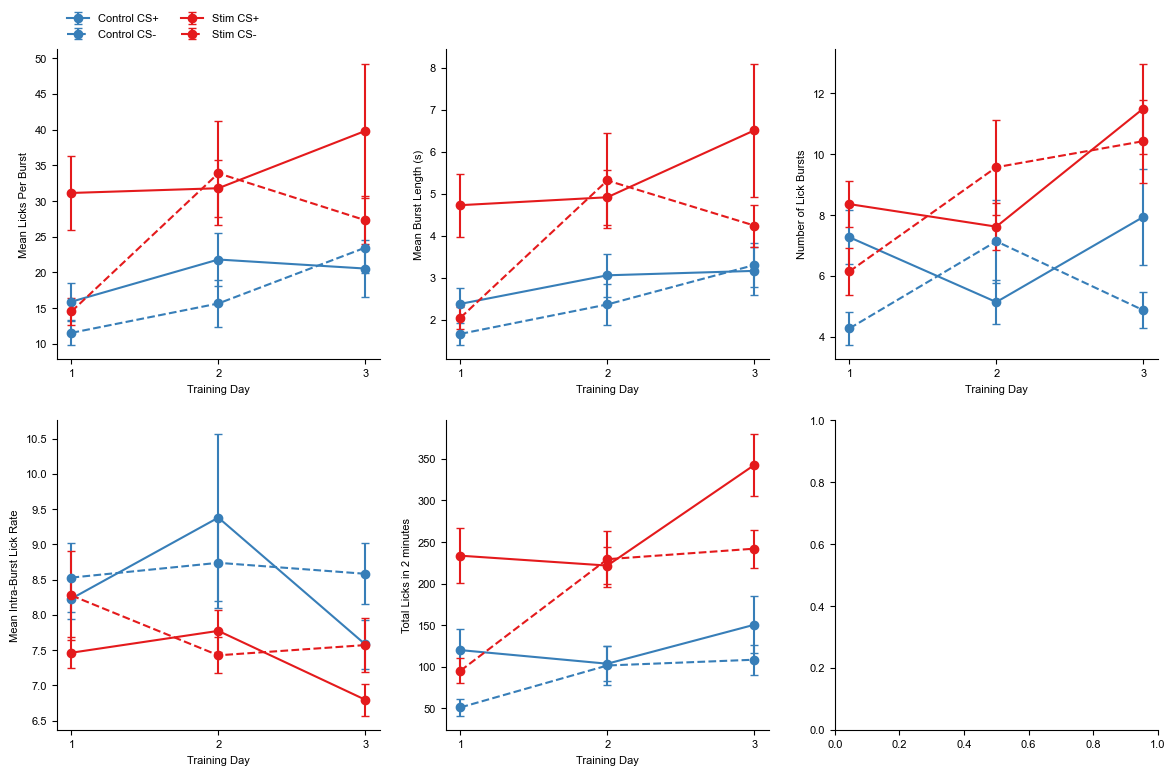

In [4]:
bursts, burst_summ = lick_microstructure(dft_train_g, 2)
fig, ax = plt.subplots(2,3, figsize = (12,8))
plot_training_micro(burst_summ, 'sizes',  ylabel = 'Mean Licks Per Burst', ax = ax[0,0]);
plot_training_micro(burst_summ, 'lens',  ylabel = 'Mean Burst Length (s)', ax = ax[0,1]);
plot_training_micro(burst_summ, 'lr',  ylabel = 'Mean Intra-Burst Lick Rate', ax = ax[1,0]);
plot_training_micro(burst_summ, 'tot',  ylabel = 'Total Licks in 2 minutes', ax = ax[1,1]);
plot_training_micro(burst_summ, 'burst_num',  ylabel = 'Number of Lick Bursts', ax = ax[0,2]);

ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[0,2].get_legend().remove()

fig.tight_layout(pad = 2.)
# fig.savefig(fig_save_loc/'pdfs'/'unltd_gluc_train_microstructure_2min.pdf', transparent=True, bbox_inches='tight')
# fig.savefig(fig_save_loc/'svgs'/'unltd_gluc_train_microstructure_2min.svg', transparent=True, bbox_inches='tight')

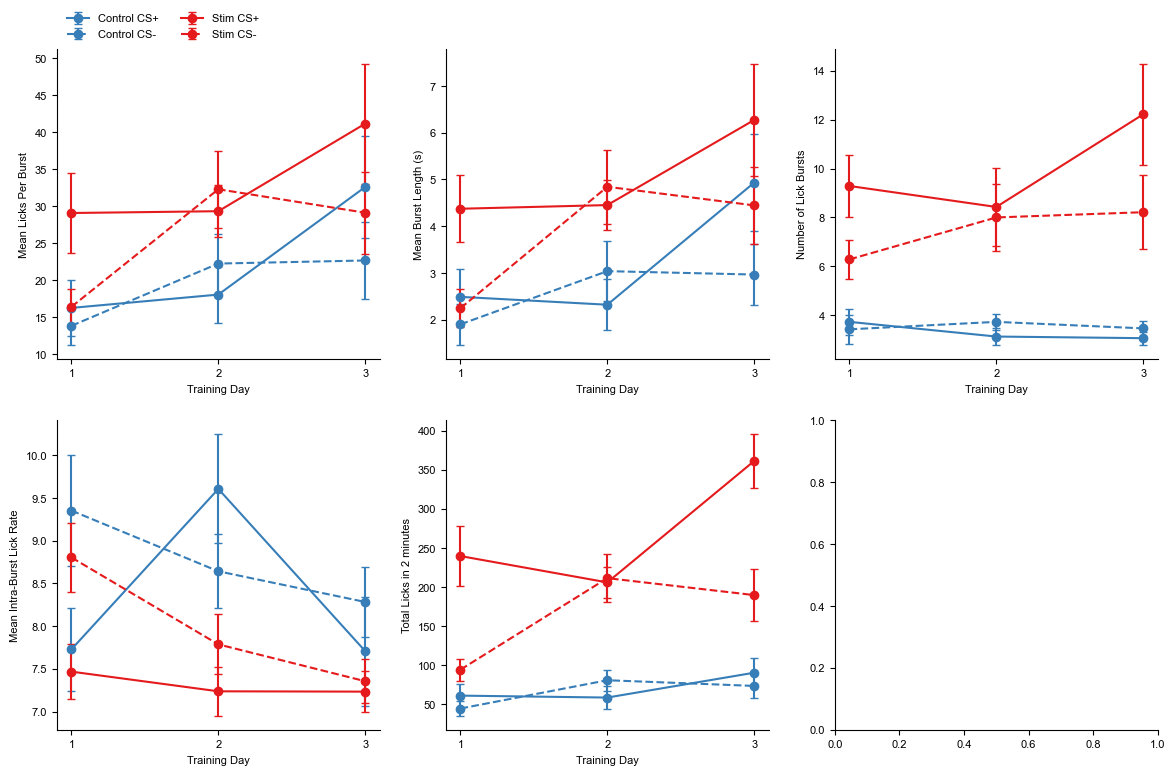

In [5]:
bursts, burst_summ = lick_microstructure(dft_train_f, 2)
fig, ax = plt.subplots(2,3, figsize = (12,8))
plot_training_micro(burst_summ, 'sizes',  ylabel = 'Mean Licks Per Burst', ax = ax[0,0]);
plot_training_micro(burst_summ, 'lens',  ylabel = 'Mean Burst Length (s)', ax = ax[0,1]);
plot_training_micro(burst_summ, 'lr',  ylabel = 'Mean Intra-Burst Lick Rate', ax = ax[1,0]);
plot_training_micro(burst_summ, 'tot',  ylabel = 'Total Licks in 2 minutes', ax = ax[1,1]);
plot_training_micro(burst_summ, 'burst_num',  ylabel = 'Number of Lick Bursts', ax = ax[0,2]);

ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[0,2].get_legend().remove()

fig.tight_layout(pad = 2.)
# fig.savefig(fig_save_loc/'pdfs'/'unltd_fat_microstructure_train_2min.pdf', transparent=True, bbox_inches='tight')
# fig.savefig(fig_save_loc/'svgs'/'unltd_fat_microstructure_train_2min.svg', transparent=True, bbox_inches='tight')

## validation of limited intake during training

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_83465/3566137536.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  training_plot(df_train_g_ltd.loc[True,], df_train_g_ltd.loc[False,],


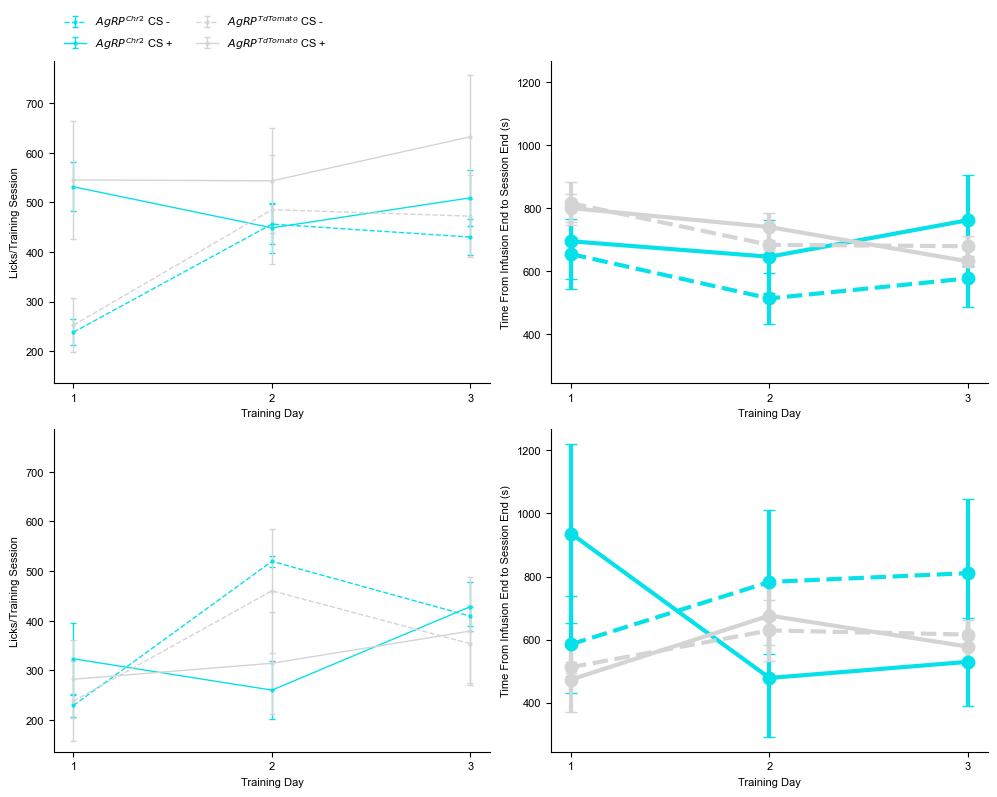

In [6]:
# create subplots
fig, ax = plt.subplots(2,2, figsize = (10,8))

# plot training licks
training_plot(df_train_g_ltd.loc[True,], df_train_g_ltd.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[0,0]);
training_plot(df_train_f_ltd.loc[True,], df_train_f_ltd.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[1,0]);


# validate that controls and stim mice had bottles for equivalent amounts of time
_, s, c = plot_t_to_end(dft_train_g_ltd.loc[True,],dft_train_g_ltd.loc[False,],
              colors = [stim_col, ctl_col], ax = ax[0,1]);
tend = pd.concat({True: s, False: c}, names = ["Chr2"])
_, s, c = plot_t_to_end(dft_train_f_ltd.loc[True,],dft_train_f_ltd.loc[False,],
              colors = [stim_col, ctl_col], ax = ax[1,1]);
tend_f = pd.concat({True: s, False: c}, names = ["Chr2"])



# remove extra legends
ax[0,1].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,0].get_legend().remove()
# ax[1,3].get_legend().remove()

# adjust y axis limits
for i in range(2):
    l = np.array([ax[0,i].get_ylim(), ax[1,i].get_ylim()])
    bnd = (l[:,0].min(), l[:,1].max())
    ax[0,i].set_ylim(bnd)
    ax[1,i].set_ylim(bnd)



#format the figure
fig.tight_layout(pad = 1.)

# save the figure
# fig.savefig(fig_save_loc/'pdfs'/'ltd_train.pdf', transparent=True, bbox_inches='tight')
# fig.savefig(fig_save_loc/'svgs'/'ltd_train.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - limited intake validation of equal training licks

In [7]:
ltd_val = (df_train_g_ltd.groupby(['day','CS'])
                         .total_licks
                         .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                         .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
ltd_val['pvalue_corr'] = multipletests(ltd_val.pvalue, method = 'holm-sidak')[1]

ltd_val_f = (df_train_f_ltd.groupby(['day','CS'])
                         .total_licks
                         .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                         .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
ltd_val_f['pvalue_corr'] = multipletests(ltd_val_f.pvalue, method = 'holm-sidak')[1]

print('glucose')
display(ltd_val)
print('\nfat')
display(ltd_val_f)

# limited_intake_stats.update({'train_ltd_val_g': ltd_val,
#                              'train_ltd_val_f': ltd_val_f})


glucose


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_83465/3239949036.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))


statistic    pvalue  pvalue_corr
day CS                                  
0   +   -0.105217  0.916804     0.993007
    -   -0.230021  0.819415     0.993007
1   +   -0.795754  0.431539     0.945466
    -   -0.243852  0.808769     0.993007
2   +   -0.881253  0.384193     0.945466
    -   -0.457561  0.650096     0.985010


fat


statistic    pvalue  pvalue_corr
day CS                                  
0   +    0.384267  0.707504     0.994340
    -   -0.105449  0.917762     0.994340
1   +   -0.459031  0.654416     0.994340
    -    0.472958  0.644730     0.994340
2   +    0.413000  0.686891     0.994340
    -    0.682769  0.507720     0.985768

##### stats - limited intake validation of equal time to end

In [8]:
tend_val = (tend.groupby(['day','CS'])
                .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
tend_val['pvalue_corr'] = multipletests(tend_val.pvalue, method = 'holm-sidak')[1]
tend_val_f = (tend_f.groupby(['day','CS'])
                .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
tend_val_f['pvalue_corr'] = multipletests(tend_val_f.pvalue, method = 'holm-sidak')[1]

print('glucose')
display(tend_val)
print('\nfat')
display(tend_val_f)

# limited_intake_stats.update({'train_tend_val_g': tend_val,
#                              'train_tend_val_f': tend_val_f})


glucose


statistic    pvalue  pvalue_corr
day CS                                  
0   +   -0.841487  0.405788     0.753946
    -   -1.252064  0.218849     0.709146
1   +   -0.781292  0.439884     0.753946
    -   -2.092926  0.043672     0.235035
2   +    0.922943  0.362356     0.753946
    -   -1.061572  0.295700     0.753946


fat


statistic    pvalue  pvalue_corr
day CS                                  
0   +    1.532405  0.151353     0.626437
    -    0.468084  0.648112     0.907339
1   +   -0.945282  0.363160     0.895251
    -    0.619003  0.547486     0.907339
2   +   -0.331149  0.746243     0.907339
    -    0.812234  0.432476     0.896262

## comparing control two bottle test performance limited vs unlimited


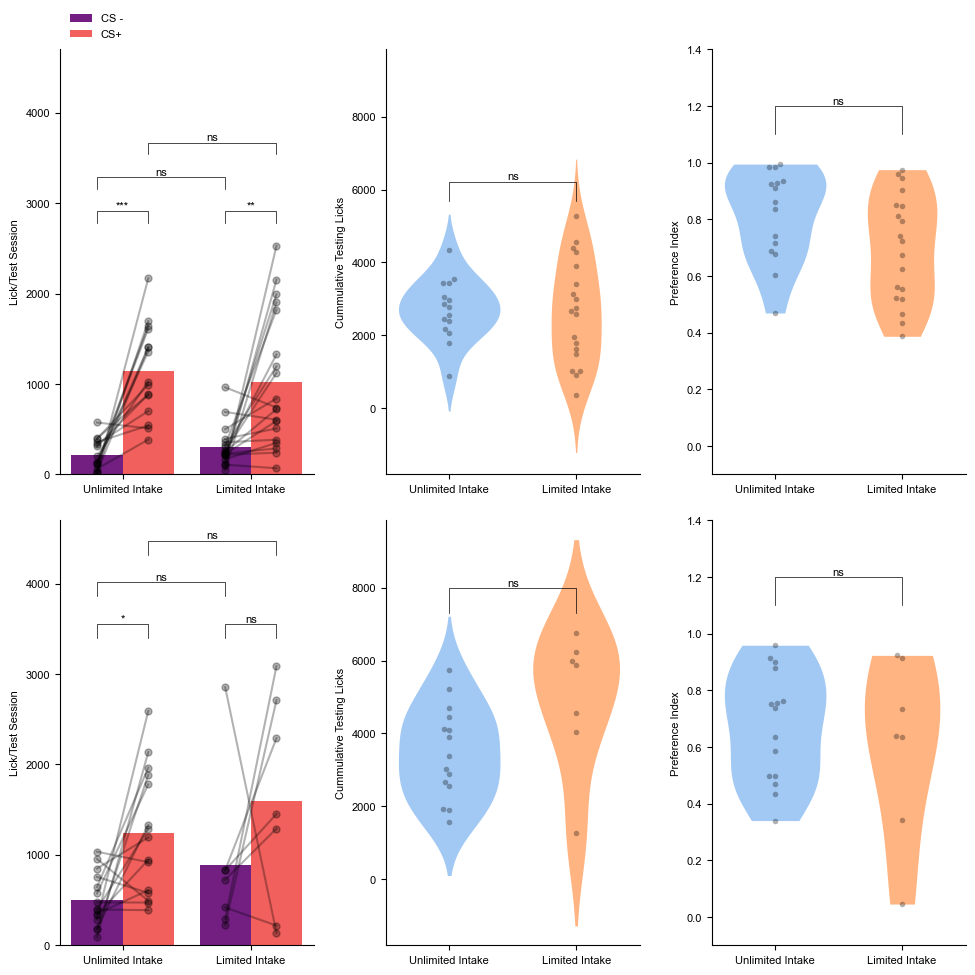

In [10]:
# glucose
normal_ctl = average_test_data(df_test_g, Chr2=False)
ltd_ctl = average_test_data(df_test_g_ltd, Chr2=False)

# fat
ltd_ctl_f = average_test_data(df_test_f_ltd, Chr2=False)
normal_ctl_f = average_test_data(df_test_f, Chr2=False)




fig, ax = plt.subplots(2,3, figsize=(10,10))

# plot mean cs+ and cs- testing licks
_, stat_ltd_unltd_g = two_bottle_plot(ltd_ctl, normal_ctl,  ax=ax[0,0],
                                      groups= ['Limited Intake', 'Unlimited Intake']);
_, stat_ltd_unltd_f = two_bottle_plot(ltd_ctl_f, normal_ctl_f,  ax=ax[1,0], t = 60,
                                      groups= ['Limited Intake', 'Unlimited Intake']);

# plot cummulative testing licks
_, stat_ltd_unltd_tot_g = cumm_test_licks_plot(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,
                                               groups= ['Limited Intake', 'Unlimited Intake'], 
                                               ax=ax[0,1], palette= sns.color_palette('pastel',2)[::-1])
_, stat_ltd_unltd_tot_f = cumm_test_licks_plot(df_test_f_ltd.loc[False,], df_test_f.loc[False,] , 
                                               groups= ['Limited Intake', 'Unlimited Intake'],
                                               ax=ax[1,1], palette= sns.color_palette('pastel',2)[::-1])

# plot lick preference index
_, _, stat_ltd_unltd_pref_g = two_bottle_pref_plot_vl(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,
                                                      groups= ['Limited Intake', 'Unlimited Intake'], 
                                                      ax=ax[0,2], palette= sns.color_palette('pastel',2)[::-1]);
_, _, stat_ltd_unltd_pref_f = two_bottle_pref_plot_vl(df_test_f_ltd.loc[False,], df_test_f.loc[False,] ,
                                                      groups= ['Limited Intake', 'Unlimited Intake'], 
                                                      ax=ax[1,2], t = 60, palette= sns.color_palette('pastel',2)[::-1]);

# remove legends
ax[1,0].get_legend().remove()

# adjust the y-limits
for i in range(3):
    l = np.array([ax[0,i].get_ylim(), ax[1,i].get_ylim()])
    bnd = (l[:,0].min(), l[:,1].max())
    ax[0,i].set_ylim(bnd)
    ax[1,i].set_ylim(bnd)
    
# format plots
fig.tight_layout(pad=2.0)

# save the figure
# fig.savefig(fig_save_loc/'pdfs'/'ltd_ctl_v_unltd_ctl.pdf', transparent=True, bbox_inches='tight')
# fig.savefig(fig_save_loc/'svgs'/'ltd_ctl_v_unltd_ctl.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - glucose unlimited vs limited mean CS+ and CS- licks

In [11]:
df = pd.concat({True: df_test_g_ltd.loc[False,], 
                False: df_test_g.loc[False,]},
               names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['limited','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.limited].total_licks, x.loc[~x.limited].total_licks), index = ('statistic', 'p-value')))
          )
anova_res = pg.mixed_anova(data = df, within = 'CS', between = 'limited', dv = 'total_licks', subject = 'mouse')
display(shapiro, levene, anova_res, stat_ltd_unltd_g)
# limited_intake_stats.update({ 'test_shapiro_ltd_unltd_g' : shapiro,
#                                'test_levene_ltd_unltd_g'  : levene ,
#                                'test_anova_ltd_unltd_g'   : anova_res,
#                                'test_posthoc_ltd_unltd_g': stat_ltd_unltd_g})


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_83465/1976743993.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()


statistic   p-value
limited CS                     
False   +    0.960600  0.702824
        -    0.911952  0.145072
True    +    0.912920  0.083764
        -    0.818898  0.002179

,statistic,p-value
CS,,
+,1.145549,0.292490
-,0.001401,0.970373


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,limited,5.985741e+03,1,32,5.985741e+03,0.033615,8.556851e-01,0.001049,NaN
1,CS,1.127024e+07,1,32,1.127024e+07,39.737856,4.517528e-07,0.553931,1.0
2,Interaction,1.970808e+05,1,32,1.970808e+05,0.694889,4.106857e-01,0.021254,NaN


,statistic,pvalue,pvalue_corr,df,paired
CS+ vs. CS- Limited Intake,3.782804,0.001363,0.004082,18,True
CS+ vs. CS- Unlimited Intake,5.623017,0.000063,0.000251,14,True
CS+ Limited Intake vs. CS+ Unlimited Intake,-0.591720,0.558248,0.558248,32,False
CS- Limited Intake vs. CS- Unlimited Intake,1.338128,0.190286,0.344364,32,False


##### stats - glucose unlimited vs limited mean CS+ and CS- licks

In [12]:
df = pd.concat({True: df_test_f_ltd.loc[False,], 
                False: df_test_f.loc[False,]},
               names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['limited','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.limited].total_licks, x.loc[~x.limited].total_licks), index = ('statistic', 'p-value')))
          )
anova_res = pg.mixed_anova(data = df, within = 'CS', between = 'limited', dv = 'total_licks', subject = 'mouse')
display(shapiro, levene, anova_res, stat_ltd_unltd_f)
# limited_intake_stats.update({ 'test_shapiro_ltd_unltd_f' : shapiro,
#                                'test_levene_ltd_unltd_f'  : levene ,
#                                'test_anova_ltd_unltd_f'   : anova_res,
#                                'test_posthoc_ltd_unltd_f': stat_ltd_unltd_f})


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_83465/2186379068.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()


statistic   p-value
limited CS                     
False   +    0.927676  0.251834
        -    0.943376  0.426726
True    +    0.924514  0.505270
        -    0.704063  0.004105

,statistic,p-value
CS,,
+,2.760479,0.112215
-,1.970012,0.175783


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,limited,1.315077e+06,1,20,1.315077e+06,4.822610,0.040050,0.194283,NaN
1,CS,5.871029e+06,1,20,5.871029e+06,7.570947,0.012305,0.274599,1.0
2,Interaction,1.232767e+03,1,20,1.232767e+03,0.001590,0.968591,0.000079,NaN


,statistic,pvalue,pvalue_corr,df,paired
CS+ vs. CS- Limited Intake,1.019706,0.347210,0.675482,6,True
CS+ vs. CS- Unlimited Intake,3.320959,0.005047,0.020037,14,True
CS+ Limited Intake vs. CS+ Unlimited Intake,0.758789,0.469533,0.675482,20,False
CS- Limited Intake vs. CS- Unlimited Intake,1.092787,0.312806,0.675482,20,False


##### stats - unlimited vs limited cummulative licks

In [13]:
stat_ltd_unltd_tot_g_df = pd.DataFrame({'ttest': stat_ltd_unltd_tot_g}, index = ['statistic', 'pvalue', 'df']).T
stat_ltd_unltd_tot_f_df = pd.DataFrame({'ttest': stat_ltd_unltd_tot_f}, index = ['statistic', 'pvalue', 'df']).T

print('glucose')
display(stat_ltd_unltd_tot_g_df)
print('\nfat')
display(stat_ltd_unltd_tot_f_df)

# limited_intake_stats.update({'test_ltd_v_unltd_tot_g': stat_ltd_unltd_tot_g_df,
#                              'test_ltd_v_unltd_tot_f': stat_ltd_unltd_tot_f_df})

glucose


,statistic,pvalue,df
ttest,-0.194396,0.84718,32.0



fat


,statistic,pvalue,df
ttest,1.893655,0.092319,20.0


##### stats - unlimited vs limited pref

In [14]:
stat_ltd_unltd_pref_g_df = pd.DataFrame({'ttest': stat_ltd_unltd_pref_g}, index = ['statistic', 'pvalue']).T
stat_ltd_unltd_pref_f_df = pd.DataFrame({'ttest': stat_ltd_unltd_pref_f}, index = ['statistic', 'pvalue']).T


print('glucose')
display(stat_ltd_unltd_pref_g_df)
print('\nfat')
display(stat_ltd_unltd_pref_f_df)

# limited_intake_stats.update({'test_ltd_v_unltd_pref_g': stat_ltd_unltd_pref_g_df,
#                              'test_ltd_v_unltd_pref_f': stat_ltd_unltd_pref_f_df})

glucose


,statistic,pvalue
ttest,89.0,0.066022



fat


,statistic,pvalue
ttest,49.0,0.836593


In [15]:
# with pd.ExcelWriter('../stats/raw/limited_intake.xlsx') as writer:  
#     for k,v in limited_intake_stats.items():
#         v.to_excel(writer, sheet_name=k)